**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import collections
import scipy
import sklearn

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KDTree
%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

По умолчанию используется метрика Миньковского с парметром p = 2, т.е. Евлидова метрика.
Score в sklearn вычисляется как mean accuracy of self.predict

апишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах). Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [2]:
# %%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        pass

    def fit(self, X, y):
        self.X_train = X
        self.Y_train = y
        self.class_num = np.unique(y).shape[0]
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X)
        return self

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            distances = pairwise_distances(X, self.X_train, metric=self.metric)
            indexes = np.argpartition(distances, self.n_neighbors,
                                      axis=1)[::, :self.n_neighbors]
        elif self.algorithm == 'kd_tree':
            distances, indexes = self.tree.query(X, k=self.n_neighbors)
        return (np.apply_along_axis(np.bincount, 1, self.Y_train[indexes],
                minlength=self.class_num)) / self.n_neighbors

    def score(self, X, y):
        predicts = self.predict(X)
        return np.mean(y == predicts)

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=3, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=3, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=3)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 1.51 ms, sys: 624 µs, total: 2.14 ms
Wall time: 1.55 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 159 µs, sys: 65 µs, total: 224 µs
Wall time: 134 µs


MyKNeighborsClassifier(algorithm='brute', metric='euclidean', n_neighbors=3)

In [10]:
%time clf.predict(X_test)

CPU times: user 5.66 ms, sys: 661 µs, total: 6.32 ms
Wall time: 4.26 ms


array([2, 2, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 2, 1])

In [11]:
%time my_clf.predict(X_test)

CPU times: user 2.11 ms, sys: 857 µs, total: 2.97 ms
Wall time: 2.03 ms


array([2, 2, 2, 0, 1, 1, 0, 0, 0, 2, 1, 1, 0, 2, 1])

In [12]:
%time clf.predict_proba(X_test)

CPU times: user 3.37 ms, sys: 0 ns, total: 3.37 ms
Wall time: 2.38 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

In [13]:
%time my_clf.predict_proba(X_test)

CPU times: user 3.88 ms, sys: 0 ns, total: 3.88 ms
Wall time: 3.02 ms


array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [58]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 1.3 ms, sys: 511 µs, total: 1.81 ms
Wall time: 4.4 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 635 µs, sys: 248 µs, total: 883 µs
Wall time: 608 µs


MyKNeighborsClassifier(algorithm='kd_tree', metric='euclidean', n_neighbors=2)

In [18]:
%time clf.predict(X_test)

CPU times: user 3.95 ms, sys: 0 ns, total: 3.95 ms
Wall time: 3.95 ms


array([1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 1, 2, 0, 1, 1])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 2.35 ms, sys: 903 µs, total: 3.25 ms
Wall time: 2.04 ms


array([1, 0, 0, 2, 1, 0, 2, 0, 2, 1, 1, 2, 0, 1, 1])

In [20]:
%time clf.predict_proba(X_test)

CPU times: user 1.27 ms, sys: 0 ns, total: 1.27 ms
Wall time: 1.02 ms


array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ]])

In [21]:
%time my_clf.predict_proba(X_test)

CPU times: user 301 µs, sys: 2.61 ms, total: 2.91 ms
Wall time: 1.5 ms


array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ]])

In [22]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [23]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [24]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [47]:
new_target = [tar for _, tar in zip(data, target) 
              if len(re.sub('[^a-zA-Z0-9]', ' ', _).split()) > 0]
new_target[:5]

[7, 4, 4, 1, 14]

In [61]:
data_tok = [re.sub('[^a-zA-Z0-9]', ' ', doc).lower().split()
            for doc in data
            if len(re.sub('[^a-zA-Z0-9]', ' ', doc).split()) > 0]
data_tok[:2]

[['i',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'i',
  'saw',
  'the',
  'other',
  'day',
  'it',
  'was',
  'a',
  '2',
  'door',
  'sports',
  'car',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  '60s',
  'early',
  '70s',
  'it',
  'was',
  'called',
  'a',
  'bricklin',
  'the',
  'doors',
  'were',
  'really',
  'small',
  'in',
  'addition',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  'this',
  'is',
  'all',
  'i',
  'know',
  'if',
  'anyone',
  'can',
  'tellme',
  'a',
  'model',
  'name',
  'engine',
  'specs',
  'years',
  'of',
  'production',
  'where',
  'this',
  'car',
  'is',
  'made',
  'history',
  'or',
  'whatever',
  'info',
  'you',
  'have',
  'on',
  'this',
  'funky',
  'looking',
  'car',
  'please',
  'e',
  'mail'],
 ['a',
  'fair',
  'number',
  'of',
  'brave',
  'souls',
  'who',
  'upgr

In [49]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [51]:
import pandas as pd

df = pd.DataFrame({'text': data_tok})
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))
vectorizer = CountVectorizer(max_features=40000)
matrix = vectorizer.fit_transform(df['text'].values)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [30]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfTransformer

In [31]:
target = np.array(new_target)

In [65]:
def k_finder(X, y, classifier, nsplit=3,
             first_k=1, last_k=10, draw_graph=False):
    results = [(sum(classifier(k)
                    .fit(X[train_index], y[train_index])
                    .score(X[test_index], y[test_index])
                    for train_index, test_index in KFold(nsplit).split(X)) / nsplit)
                        for k in range(first_k, last_k + 1)]
    if draw_graph:
        print(results)
        plt.plot(range(first_k, last_k + 1), results)
    print("Оптимальное число соседей:", results.index(max(results)) + 1,
          "с качаством на кросс валидации:", max(results))
    return results.index(max(results)) + 1

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

[0.2153762268266085, 0.19020356234096694, 0.18938567793529626, 0.1855688840421665, 0.1896583060705198, 0.19138495092693564, 0.1943838604143948, 0.19665576154125772, 0.1984732824427481, 0.1963831334060342]
Оптимальное число соседей: 1 с качаством на кросс валидации: 0.2153762268266085


1

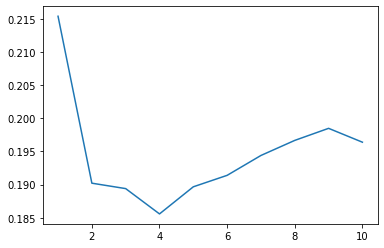

In [33]:
k_finder(matrix, 
         target, 
         lambda k: MyKNeighborsClassifier(
             n_neighbors=k, 
             algorithm='brute'
         ),
         draw_graph=True)

[0.2997091966557615, 0.2790803344238459, 0.27753544165757904, 0.2733551435841512, 0.27090149036713923, 0.2643584151217739, 0.26535805161759357, 0.2649945474372955, 0.26190476190476186, 0.25608869501999276]
Оптимальное число соседей: 1 с качаством на кросс валидации: 0.2997091966557615


1

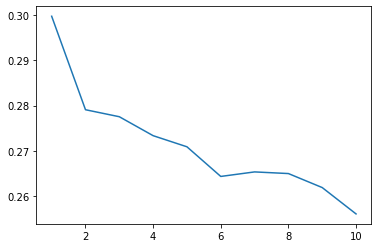

In [34]:
k_finder(matrix, 
         target, 
         lambda k: MyKNeighborsClassifier(
             n_neighbors=k, 
             algorithm='brute', 
             metric='cosine'
         ),
         draw_graph=True)

# Применим Tfldf преобразование

In [35]:
from sklearn.pipeline import Pipeline

In [36]:
text_clf = lambda k: Pipeline([
    ('tfidf', TfidfTransformer()), 
    ('clf', MyKNeighborsClassifier(
        n_neighbors=k, 
        algorithm='brute'))
])

[0.16266812068338787, 0.10805161759360234, 0.24000363504180297, 0.3462377317339149, 0.43484187568157034, 0.5512540894220284, 0.5791530352599056, 0.591875681570338, 0.5953289712831697, 0.5958742275536169]
Оптимальное число соседей: 10 с качаством на кросс валидации: 0.5958742275536169


10

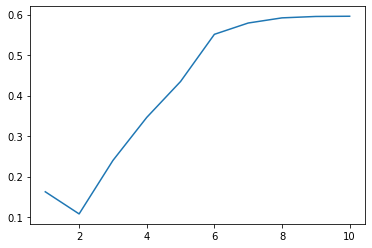

In [37]:
k_finder(matrix, target, text_clf, draw_graph=True)

In [38]:
text_clf = lambda k: Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MyKNeighborsClassifier(
        n_neighbors=k, 
        algorithm='brute',
        metric='cosine'))
])

[0.6169574700109051, 0.5769720101781171, 0.5873318793166121, 0.596419483824064, 0.5986913849509269, 0.5949654671028717, 0.5970556161395856, 0.5956924754634678, 0.5972373682297346, 0.5943293347873501]
Оптимальное число соседей: 1 с качаством на кросс валидации: 0.6169574700109051


1

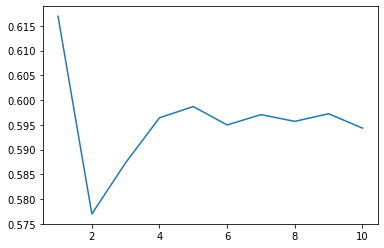

In [39]:
k_finder(matrix, target, text_clf, draw_graph=True)

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [40]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [52]:
y_test = newsgroups['data']
target_test = newsgroups['target']

In [53]:
data_tok = [re.sub('[^a-zA-Z0-9]', ' ', doc).lower().split() for doc in data_test]

In [54]:
df = pd.DataFrame({'text': data_tok})

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x]))

X_test = vectorizer.transform(df['text'].values)

In [55]:
X_test

<7532x40000 sparse matrix of type '<class 'numpy.int64'>'
	with 650171 stored elements in Compressed Sparse Row format>

In [46]:
text_clf = Pipeline([
    ('tfidf', TfidfTransformer()),
    ('clf', MyKNeighborsClassifier(
        n_neighbors=1, 
        algorithm='brute',
        metric='cosine'))
])
text_clf.fit(matrix, target)
text_clf.score(X_test, y_test)

0.5073021773765268